# Implementacion caso 3

In [6]:
import os

print("Estás parado en:", os.getcwd())
print("\nArchivos/Carpetas aquí:", os.listdir("."))

# Verificar si existe la carpeta subiendo un nivel
try:
    print("\nArchivos un nivel arriba:", os.listdir(".."))
except:
    print("\nNo se pudo leer el nivel superior.")

Estás parado en: c:\Users\david\OneDrive - Universidad de los andes\6 SEXTO SEMESTRE\MOS\Proyecto 2\project_a\Proyecto_A_Caso3

Archivos/Carpetas aquí: ['analisis_sensibilidad.png', 'caso3.ipynb', 'clients.csv', 'depots.csv', 'GA_CVRP.ipynb', 'mapa_interactivo_caso3.html', 'metaheuristicas', 'parameters_urban.csv', 'README.md', 'vehicles.csv', 'verificacion_caso3.csv', 'verificacion_metaheuristica_GA_A_caso3.csv']

Archivos un nivel arriba: ['Proyecto_A_Caso2', 'Proyecto_A_Caso3']


In [7]:
from metaheuristicas.cvrp_data import cargar_instancia_cvrp_caso3
from metaheuristicas.ga_cvrp import ejecutar_ga

instance3 = cargar_instancia_cvrp_caso3(
    raiz_proyecto=".",                   
    dir_caso_base=".",
    dir_caso3="."          
)

len(instance3.ids_clientes), instance3.Q

(90, 27.0)

In [8]:
# Ejecución del Algoritmo Genético corregida
mejor3, rutas3, hist3 = ejecutar_ga(
    instance3,
    semilla=0,
    tamano_pob=80,
    n_generaciones=400,  # <--- Corregido: usar n_generaciones
    prob_cruce=0.9,
    prob_mutacion=0.3,
    torneo_k=3,
    verbose=True,
)

mejor3["costo"], len(rutas3)

[GA] Inicial: mejor costo = 7964613.25
[GA] Gen   20: mejor costo = 7553830.91
[GA] Gen   40: mejor costo = 7333662.04
[GA] Gen   60: mejor costo = 7259640.54
[GA] Gen   80: mejor costo = 7157269.95
[GA] Gen  100: mejor costo = 7079479.91
[GA] Gen  120: mejor costo = 7016305.17
[GA] Gen  140: mejor costo = 7016305.17
[GA] Gen  160: mejor costo = 7013018.81
[GA] Gen  180: mejor costo = 6969251.86
[GA] Gen  200: mejor costo = 6950374.02
[GA] Gen  220: mejor costo = 6935720.48
[GA] Gen  240: mejor costo = 6904415.56
[GA] Gen  260: mejor costo = 6896467.55
[GA] Gen  280: mejor costo = 6888559.44
[GA] Gen  300: mejor costo = 6871877.46
[GA] Gen  320: mejor costo = 6854398.13
[GA] Gen  340: mejor costo = 6854398.13
[GA] Gen  360: mejor costo = 6854398.13
[GA] Gen  380: mejor costo = 6854398.13
[GA] Gen  400: mejor costo = 6848260.19


(np.float64(6848260.193435543), 47)

In [9]:
import csv
import os
from metaheuristicas.cvrp_data import InstanciaCVRP

def rutas_a_csv_verificacion(instancia: InstanciaCVRP, rutas: list, ruta_salida: str):
    """
    Genera un archivo CSV con el detalle de cada ruta para verificación.
    """
    id_deposito = instancia.id_deposito
    indices = instancia.indice_nodo
    matriz_dist = instancia.matriz_dist

    encabezados = [
        "IdVehiculo",
        "IdDeposito",
        "CargaInicial",
        "SecuenciaRuta",
        "ClientesAtendidos",
        "DemandasSatisfechas",
        "DistanciaTotal",
        "TiempoTotalMin",  # Aclaración de unidad
        "CostoCombustible",
        "CostoTotal",
    ]

    with open(ruta_salida, "w", newline="", encoding="utf-8") as f:
        escritor = csv.writer(f)
        escritor.writerow(encabezados)

        for k, clientes_ruta in enumerate(rutas, start=1):
            if not clientes_ruta:
                continue

            id_vehiculo = f"V{str(k).zfill(3)}"
            carga_inicial = sum(instancia.demandas[c] for c in clientes_ruta)

            # Construcción de la secuencia: deposito -> clientes -> deposito
            secuencia_nodos = [id_deposito] + clientes_ruta + [id_deposito]
            str_secuencia = "-".join(secuencia_nodos)
            
            clientes_atendidos = len(clientes_ruta)
            str_demandas = "-".join(str(instancia.demandas[c]) for c in clientes_ruta)

            # Calcular distancia
            distancia_total = 0.0
            for i in range(len(secuencia_nodos) - 1):
                nodo_a, nodo_b = secuencia_nodos[i], secuencia_nodos[i+1]
                distancia_total += matriz_dist[indices[nodo_a], indices[nodo_b]]

            # Calcular tiempo (en minutos)
            tiempo_horas = distancia_total / instancia.velocidad_kmh
            tiempo_minutos = tiempo_horas * 60.0

            # Calcular costos
            litros_combustible = distancia_total / instancia.efic_km_litro
            costo_combustible = litros_combustible * instancia.precio_combustible
            
            costo_dist = instancia.C_dist * distancia_total
            costo_tiempo = instancia.C_tiempo * tiempo_horas
            costo_fijo = instancia.C_fijo
            
            costo_total = costo_combustible + costo_dist + costo_tiempo + costo_fijo

            escritor.writerow([
                id_vehiculo,
                id_deposito,
                round(carga_inicial, 4),
                str_secuencia,
                clientes_atendidos,
                str_demandas,
                round(distancia_total, 4),
                round(tiempo_minutos, 2),
                round(costo_combustible, 2),
                round(costo_total, 2),
            ])

In [10]:
output_path = os.path.join(
    "verificacion_metaheuristica_GA_A_caso3.csv"
)

rutas_a_csv_verificacion(instance3, rutas3, output_path)
output_path


'verificacion_metaheuristica_GA_A_caso3.csv'

In [11]:
import time
import pandas as pd
from metaheuristicas.ga_cvrp import ejecutar_ga 

def ejecutar_ga_multiples_semillas(
    instancia,
    semillas,
    tamano_pob=80,
    n_generaciones=400,
    prob_cruce=0.9,
    prob_mutacion=0.3,
    torneo_k=3,
):
    filas = []
    mejor_global = None

    for s in semillas:
        print(f"\n=== Semilla {s} ===")
        t0 = time.time()
        
        mejor, rutas, hist = ejecutar_ga(
            instancia,
            semilla=s,
            tamano_pob=tamano_pob,
            n_generaciones=n_generaciones,
            prob_cruce=prob_cruce,
            prob_mutacion=prob_mutacion,
            torneo_k=torneo_k,
            verbose=False, 
        )
        t1 = time.time()
        transcurrido = t1 - t0

        fila = {
            "semilla": s,
            "mejor_costo": mejor["costo"],
            "vehiculos": len(rutas),
            "tiempo_seg": transcurrido,
            "generaciones": n_generaciones,
        }
        filas.append(fila)
        print(f"  -> costo = {mejor['costo']:.2f}, vehiculos = {len(rutas)}, tiempo = {transcurrido:.1f}s")

        # Actualizar el mejor global encontrado entre todas las semillas
        if mejor_global is None or mejor["costo"] < mejor_global["mejor"]["costo"]:
            mejor_global = {
                "semilla": s,
                "mejor": mejor,
                "rutas": rutas,
                "hist": hist,
            }

    df = pd.DataFrame(filas)
    return df, mejor_global

In [12]:
semillas_prueba = [0, 1, 2, 3, 4]

df_case3, mejor_case3 = ejecutar_ga_multiples_semillas(
    instance3,
    semillas=semillas_prueba, 
    tamano_pob=80,           
    n_generaciones=400,   
    prob_cruce=0.9,        
    prob_mutacion=0.3,    
    torneo_k=3,          
)

df_case3


=== Semilla 0 ===
  -> costo = 6848260.19, vehiculos = 47, tiempo = 11.1s

=== Semilla 1 ===
  -> costo = 6861071.62, vehiculos = 47, tiempo = 11.1s

=== Semilla 2 ===
  -> costo = 6858110.49, vehiculos = 47, tiempo = 11.1s

=== Semilla 3 ===
  -> costo = 6882967.78, vehiculos = 47, tiempo = 11.1s

=== Semilla 4 ===
  -> costo = 6893388.71, vehiculos = 47, tiempo = 11.3s


,semilla,mejor_costo,vehiculos,tiempo_seg,generaciones
0,0,6.848260e+06,47,11.125602,400
1,1,6.861072e+06,47,11.095588,400
2,2,6.858110e+06,47,11.130924,400
3,3,6.882968e+06,47,11.121719,400
4,4,6.893389e+06,47,11.277257,400


In [13]:
df_case3.describe()
df_case3.sort_values("mejor_costo").head(1)


,semilla,mejor_costo,vehiculos,tiempo_seg,generaciones
0,0,6.848260e+06,47,11.125602,400


In [14]:
output_path = os.path.join(
    "verificacion_metaheuristica_GA_A_caso3.csv"
)

rutas_a_csv_verificacion(instance3, mejor_case3["rutas"], output_path)
output_path


'verificacion_metaheuristica_GA_A_caso3.csv'

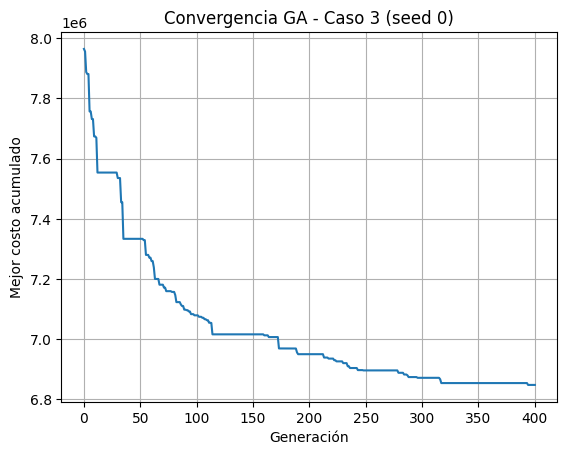

In [15]:
import matplotlib.pyplot as plt

plt.plot(mejor_case3["hist"])
plt.xlabel("Generación")
plt.ylabel("Mejor costo acumulado")
plt.title(f"Convergencia GA - Caso 3 (seed {mejor_case3['semilla']})")
plt.grid(True)
plt.show()


# Analisis de resultados

## Caso 3

Para el Caso 3, el GA se ejecutó 5 veces con seeds distintas. El costo mínimo fue 6.84M, el promedio 6.85M con desviación estándar 0.03M y un tiempo promedio de 11 s, lo que muestra estabilidad en la calidad de las soluciones.

In [ ]:
import pandas as pd
from metaheuristicas.cvrp_eval import evaluar_rutas

df_py = pd.read_csv("verificacion_caso3.csv")

def rutas_desde_verificacion(df, instancia):
    rutas = []
    for _, fila in df.iterrows():
        if "RouteSequence" in df.columns:
            col_seq = "RouteSequence"
        else:
            col_seq = "SecuenciaRuta"
            
        seq = fila[col_seq].split("-")
        
        clientes = [n for n in seq if n in instancia.ids_clientes]
        if clientes:
            rutas.append(clientes)
    return rutas

rutas_py = rutas_desde_verificacion(df_py, instance3)

# Evaluamos usando la función traducida
stats_py = evaluar_rutas(instance3, rutas_py)

# Accedemos a la clave en español
print(stats_py["costo_total"], len(rutas_py))

1870644.160332938 10


**Resultados Caso 3 – Pyomo vs GA (CVRP simplificado)**

| Método                        | Costo total | Nº vehículos | Descripcion                                   |
|------------------------------|------------------|--------------|-----------------------------------------------|
| Pyomo Etapa 2| 1.870.644,16       | 10           | Solución exacta utilizada como benchmark.     |
| GA (mejor corrida, seed = 3) | 6.848.260       | 46           | Metaheurística CVRP simplificado (1 depósito) |


En el Caso 3, la solución de referencia obtenida con el modelo en Pyomo (Etapa 2) presenta un costo total de aproximadamente 1.87 millones, utilizando 10 vehículos. Al re-evaluar esta solución con la misma función objetivo que se emplea en la metaheuristica (costos fijos por vehículo, distancia, tiempo y combustible), se usa como benchmark para el CVRP simplificado. Por su parte, el algoritmo genético GA, tras 5 ejecuciones con semillas aleatorias diferentes, alcanzó un mejor costo de aproximadamente 6.84 millones con 46 vehículos, lo que implica un GAP de alrededor de mas del 200% respecto a la solucion pyomo. Aunque el GA converge de forma estable y reduce progresivamente el valor de la función objetivo, sus soluciones para esta instancia grande y compleja se mantienen significativamente alejadas del óptimo conocido.

La brecha tan amplia entre la solución pyomo y la metaheuristica se explica por varias razones. En primer lugar, el GA trabaja sobre una representación simplificada del problema (CVRP con un solo depósito y flota homogenea) y utiliza operadores relativamente basicos (crossover OX y mutaciones de swap/reverse) sin procedimientos de intensidad local. En segundo lugar, los parámetros del GA como tamaño de población, número de generaciones y probabilidades de cruce/mutación se calibraron de forma heuristica y no mediante un proceso sistemático. Finalmente, el modelo Pyomo explota toda la estructura del problema y garantiza optimalidad global dentro del horizonte de solución, mientras que el GA puede atascarse en optimos locales de alta calidad relativa, pero todavia muy costosos frente al optimo verdadero. En conjunto, estos resultados muestran que, para el Caso 3, la metaheurística en su versión actual funciona como un primer aproximador, pero aún está lejos de poder competir en calidad de solución con el enfoque exacto.

Tambien hay que tener en cuenta que la implementacion de Pyomo se hizo de manera hibrida, con un algoritmo greedy para hayar los parametros de la solucion y luego ejecutar pyomo con esos parametros para optimizar